In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import sys

seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

# os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']




# Open training and testing data

In [4]:
sample_0 = np.load('toymc_0.npy')
sample_1 = np.load('toymc_1.npy')

label_train = sample_0[:,3]
sample_train = sample_0[:,0:3]
label_test = sample_1[:,3]
sample_test = sample_1[:,0:3]

# Build model

In [5]:
model = Sequential()
model.add(Dense(16, input_shape=(3,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(1, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='sigmoid', name='sigmoid'))

2025-04-03 13:36:16.740041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Pruning

In [6]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# Here, 0.1 means that 10% of the weights will be forced to be 0.
pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.1, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Do training and save the result when the "Train" flag is true
# Or it will take the previous trained result

In [7]:
train = True
if train:
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss=['binary_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='my_model_2',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        sample_train,
        label_train,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    model = strip_pruning(model)    
    model.save('my_model_2/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model

    model = load_model('my_model_2/KERAS_check_best_model.keras')
    


Epoch 1/30
147/147 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.7090
***callbacks***
saving losses to my_model_2/losses.log

Epoch 1: val_loss improved from inf to 0.71521, saving model to my_model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.71521, saving model to my_model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to my_model_2/KERAS_check_model_last.h5

Epoch 1: saving model to my_model_2/KERAS_check_model_last_weights.h5

***callbacks end***

147/147 [==============================] - 4s 7ms/step - loss: 1.2446 - accuracy: 0.7090 - val_loss: 0.7152 - val_accuracy: 0.5473 - lr: 1.0000e-04
Epoch 2/30
127/147 [========================>.....] - ETA: 0s - loss: 0.3451 - accuracy: 0.9148
***callbacks***
saving losses to my_model_2/losses.log

Epoch 2: val_loss improved from 0.71521 to 0.42331, saving model to my_model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.71521 to 0.42331, saving model to my_mode

# Check the sparsity result

% of zeros = 0.10416666666666667


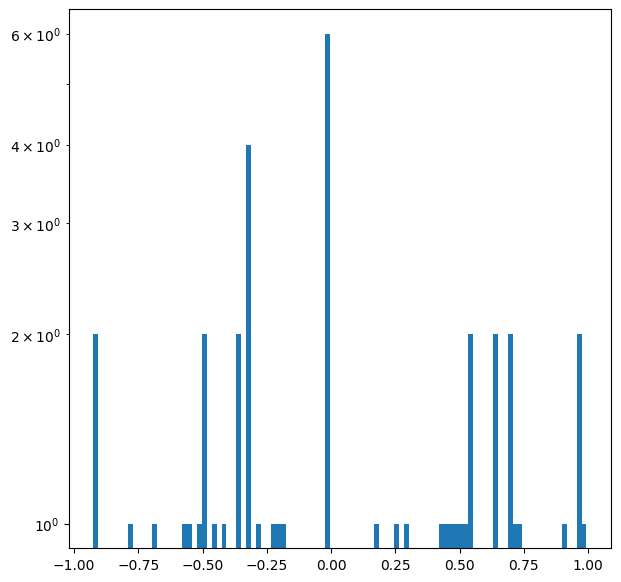

In [8]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

# Process the testing sample

In [9]:
y_keras = model.predict(sample_test)

6250/6250 [==============================] - 6s 915us/step


# Check the testing result with a cut on 0.5 and compraing to the expected label

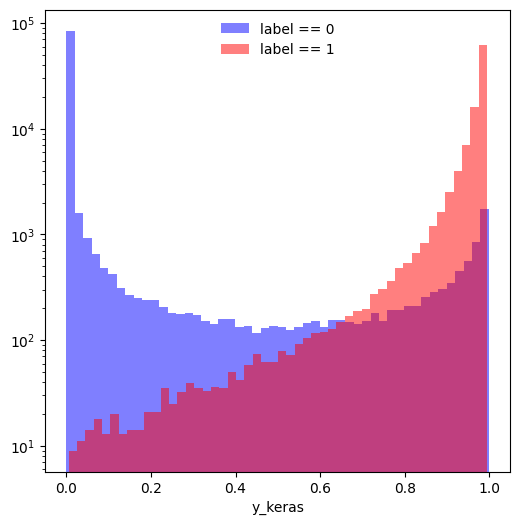

In [10]:
y_keras_sig = y_keras[ (label_test > 0 ) ]
y_keras_bkg = y_keras[ (label_test < 1) ]

plt.figure(figsize=(6,6))
plt.hist(y_keras_bkg,log=True,bins=50,label='label == 0',alpha=0.5,color='blue')
plt.hist(y_keras_sig,log=True,bins=50,label='label == 1',alpha=0.5,color='red')
plt.legend().get_frame().set_alpha(0)
plt.xlabel('y_keras')
plt.show()

Accuracy: 95.86%


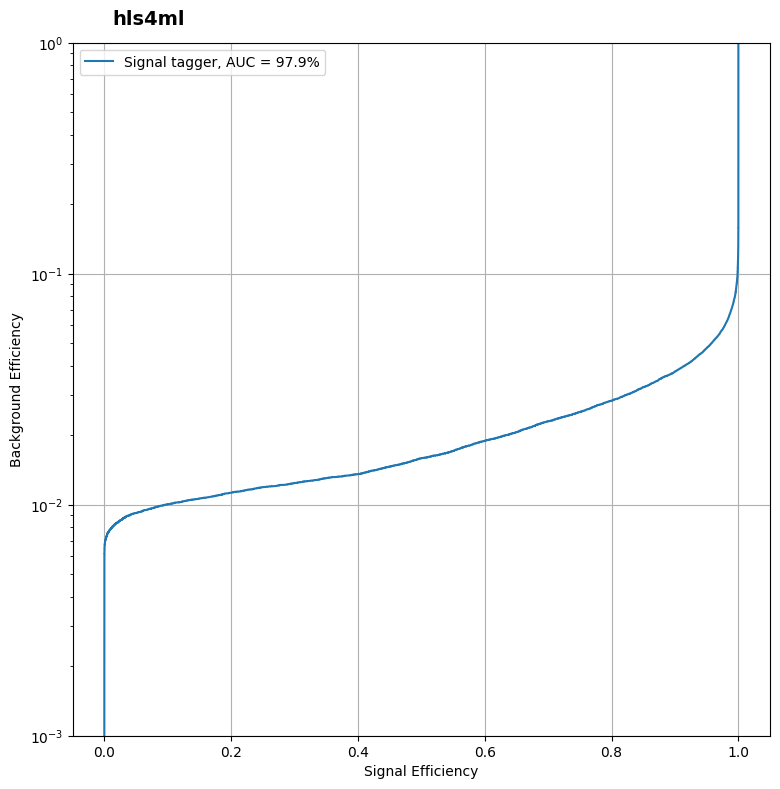

In [11]:
y_pred_binary = (y_keras > 0.5).astype(int)
accuracy = accuracy_score(label_test, y_pred_binary)
print("Accuracy: {:.2f}%".format(accuracy * 100))

label_test_reshape = label_test.reshape(len(label_test),1)
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(label_test_reshape, y_keras, ['Signal'])
plt.show()

# Build hls4ml model

In [12]:
# To create the text files to be used in later HLS Csimulation
import csv

with open('my_model_2/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(sample_test)

with open('my_model_2/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(y_keras)


In [13]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='my_model_2/hls4ml_prj', part='xc7a200tsbg484-1',
    input_data_tb = "my_model_2/Input.dat",
    output_data_tb = "my_model_2/Output.dat"
)
# "part" is the FPGA part of the Nexys video card
# By default, it will use Vivado HLS for backend
# If you use newer version of Xilinx software, you need to include backend='Vitis' in the argument to use Vitis HLS.
# Use io_type="io_parallel" in the argument to input all the bits in parallel

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: fc1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc2, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 1]
Layer name: sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  Tr

/Users/yubo/anaconda3/envs/hls4ml/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


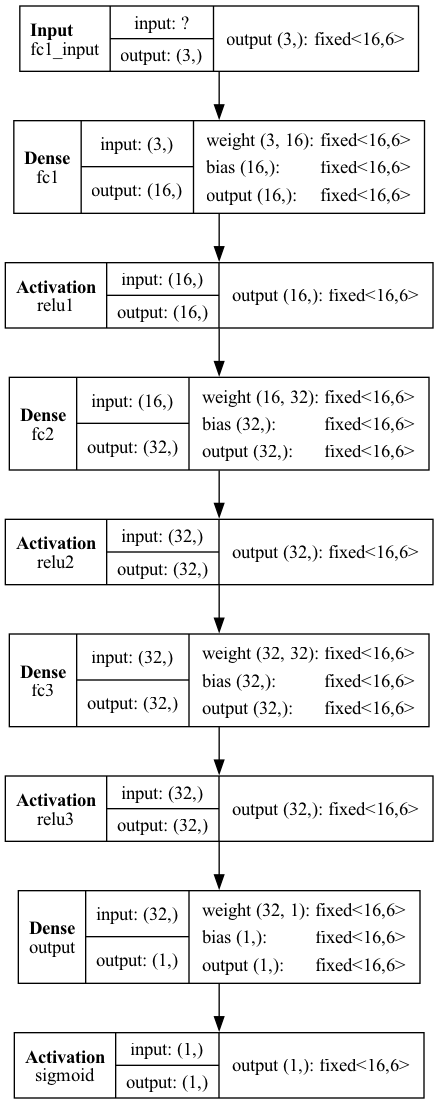

In [14]:
# This is to show the hls4ml model structure
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file='hls_model.png')
Image('hls_model.png')

In [15]:
# Compile it
hls_model.compile()

Writing HLS project
Done


# Process the testing data with hls4ml model and see the performance

Accuracy Keras: 95.86%
Accuracy HLS: 48.35%


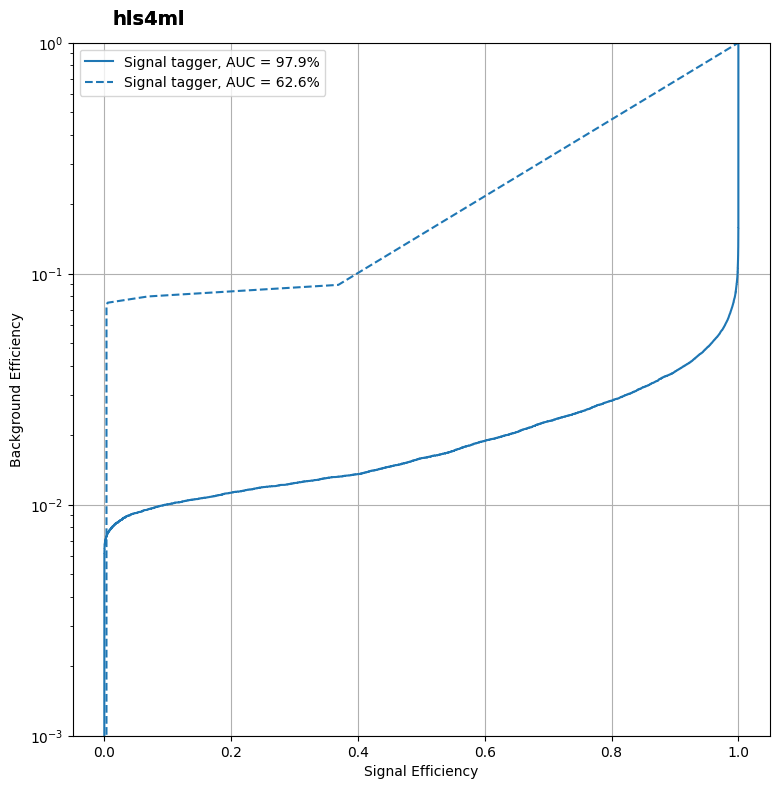

In [16]:
y_hls = hls_model.predict(np.ascontiguousarray(sample_test))

y_pred_binary_hls = (y_hls > 0.5).astype(int)
accuracy_hls = accuracy_score(label_test, y_pred_binary_hls)
print("Accuracy Keras: {:.2f}%".format(accuracy * 100))
print("Accuracy HLS: {:.2f}%".format(accuracy_hls * 100))

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(label_test_reshape, y_keras, ['Signal'])
plt.gca().set_prop_cycle(None)  
_ = plotting.makeRoc(label_test_reshape, y_hls, ['Signal'], linestyle='--')
plt.show()

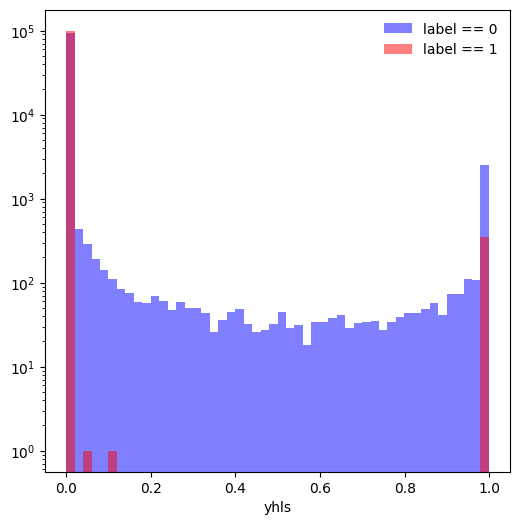

In [17]:
y_hls_sig = y_hls[ (label_test > 0 ) ]
y_hls_bkg = y_hls[ (label_test < 1) ]

plt.figure(figsize=(6,6))
plt.hist(y_hls_bkg,log=True,bins=50,label='label == 0',alpha=0.5,color='blue')
plt.hist(y_hls_sig,log=True,bins=50,label='label == 1',alpha=0.5,color='red')
plt.legend().get_frame().set_alpha(0)
plt.xlabel('yhls')
plt.show()

# Create the Vivado HLS project and do C simulation

In [ ]:
# This requires the environment variable for Xilinx Vivado being included.
# For instance, you need to run:
# source /tools/Xilinx/Vivado/2019.2/settings64.sh
# Since we set csim and cosim as True to start simulation, it takes few min.
hls_model.build(synth=True,csim=True,cosim=True)

In [ ]:
# The Vivado HLS project will be created
hls4ml.report.read_vivado_report('my_model_2/hls4ml_prj')
